In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/migraine-classification/data.csv


In [2]:
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
data = pd.read_csv("/kaggle/input/migraine-classification/data.csv")

In [4]:
data.columns = [x.lower() for x in data.columns]

**Visualize Target Class**

<AxesSubplot:>

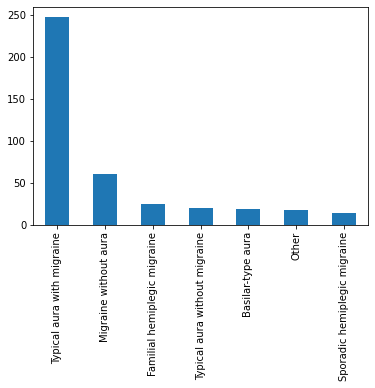

In [5]:
# class imbalance

data['type'].value_counts().plot(kind="bar")

In [6]:
# encode the target variable

le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

**Explore Features**

In [7]:
dictionary = {}
cols = data.columns
for col in cols:
    unique = len(data[col].unique())
    dtype = data[col].dtypes
    
    dictionary[col] = (unique, dtype)
    
dictionary

{'age': (51, dtype('int64')),
 'duration': (3, dtype('int64')),
 'frequency': (8, dtype('int64')),
 'location': (3, dtype('int64')),
 'character': (3, dtype('int64')),
 'intensity': (4, dtype('int64')),
 'nausea': (2, dtype('int64')),
 'vomit': (2, dtype('int64')),
 'phonophobia': (2, dtype('int64')),
 'photophobia': (2, dtype('int64')),
 'visual': (5, dtype('int64')),
 'sensory': (3, dtype('int64')),
 'dysphasia': (2, dtype('int64')),
 'dysarthria': (2, dtype('int64')),
 'vertigo': (2, dtype('int64')),
 'tinnitus': (2, dtype('int64')),
 'hypoacusis': (2, dtype('int64')),
 'diplopia': (2, dtype('int64')),
 'defect': (2, dtype('int64')),
 'ataxia': (1, dtype('int64')),
 'conscience': (2, dtype('int64')),
 'paresthesia': (2, dtype('int64')),
 'dpf': (2, dtype('int64')),
 'type': (7, dtype('O')),
 'type_encoded': (7, dtype('int64'))}

In [8]:
# split features into continuous and categorical

continuous_variables = ['age']
categorical_variables = ['duration','frequency','location','character','intensity','nausea','vomit',
                        'phonophobia','photophobia','visual','sensory','dysphasia','dysarthria','vertigo',
                        'tinnitus','hypoacusis','diplopia','defect','ataxia','conscience','paresthesia',
                        'dpf']

In [9]:
# check for missing values

data.isna().sum()

age             0
duration        0
frequency       0
location        0
character       0
intensity       0
nausea          0
vomit           0
phonophobia     0
photophobia     0
visual          0
sensory         0
dysphasia       0
dysarthria      0
vertigo         0
tinnitus        0
hypoacusis      0
diplopia        0
defect          0
ataxia          0
conscience      0
paresthesia     0
dpf             0
type            0
type_encoded    0
dtype: int64

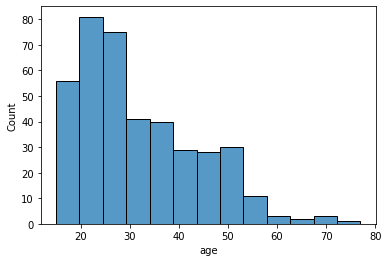

In [10]:
ax = sns.histplot(x=data['age'])
plt.show()

Only one column is numerical. Everything else is boolean or categorical.

Age is right skewed and will need transformation.

**Independence and Correlation Testing**

In [11]:
# define function that tests independence between two categorical values

def check_cat_cat_ind(data, col1, col2):
    cross_tab = pd.crosstab(data[col1],data[col2])
    
    stat, p, dof, expected = chi2_contingency(cross_tab)
    
    return p

In [12]:
# define function that tests independence between categorical and continuous

def check_cat_cont_ind(data, col1, col2):
    s, p = stats.f_oneway(data['age'], data['type_encoded'])
    
    return p

In [13]:
results = pd.DataFrame(columns = ['column','p-value'])

for var in continuous_variables:
    p = check_cat_cont_ind(data, var, "type_encoded")
    results = results.append({'column': var, 'p-value': p}, ignore_index=True)
    
for var in categorical_variables:
    p = check_cat_cat_ind(data, var, "type_encoded")
    results = results.append({'column': var, 'p-value': p}, ignore_index=True)
    

In [14]:
# Every feature except for ataxia is meaningful / has some impact on our target value

results.sort_values(by=['p-value'], ascending=True)

,column,p-value
0,age,2.856593e-222
4,character,2.261615e-132
3,location,3.076542e-122
5,intensity,1.919289e-101
10,visual,2.698760e-76
8,phonophobia,4.963241e-42
9,photophobia,5.003330e-37
14,vertigo,9.393514e-33
18,defect,1.828978e-25
16,hypoacusis,1.828978e-25


**Clean and Transform Data**

There are no missing values - no cleaning

All features are categorical (numerically encoded) - no cleaning

Age is right skewed - apply log transform

Data is unbalanced, so we will need to resample

In [15]:
from sklearn.utils import resample, shuffle

In [16]:
def upsample_minorities(data, target_feature):
    majority = data[target_feature].value_counts().reset_index()['index'][0]
    minorities = data[target_feature].value_counts().reset_index()['index'][1:].values
    
    majority_df = data[data[target_feature]==majority]
    
    upsampled_dfs = []
    upsampled_dfs.append(majority_df)
    
    for minority in minorities:
        
        minority_df = data[data[target_feature]==minority]
        
        minority_upsampled = resample(minority_df,
                          replace=True, # sample with replacement
                          n_samples=len(majority_df), # match number in majority class
                          random_state=42) 
        
        upsampled_dfs.append(minority_upsampled)
        
    ret = pd.concat(upsampled_dfs)
    ret = shuffle(ret).reset_index(drop=True)
    
    return ret
        
        
    

In [17]:
# transform age to log_age
data['age'] = np.log(data['age'])

skewness has been mitigated


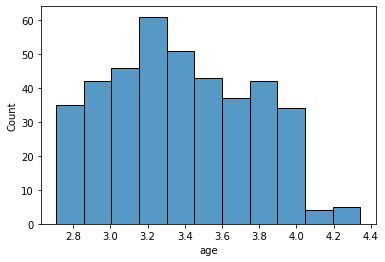

In [18]:
ax = sns.histplot(data['age'])

print("skewness has been mitigated")

**One Hot Encode Categorical**

In [19]:
numerical_df = data[continuous_variables]
categorical_df = data[categorical_variables]
target = data['type_encoded']
categorical_df = categorical_df.astype(str)
ohe_categorical = pd.get_dummies(categorical_df)

In [20]:
ohe_df = numerical_df.join(ohe_categorical)
features = ohe_df.columns
ohe_df['type_encoded'] = target

**Testing out linear model**

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

In [22]:
shuffled = shuffle(ohe_df).reset_index()

In [23]:
test_threshold = int(np.floor(shuffled.shape[0] * .324))

In [24]:
test = shuffled.iloc[0:test_threshold, :]
train = shuffled.iloc[test_threshold:,:]

In [25]:
upsampled_train = upsample_minorities(train, "type_encoded")

In [26]:
X_train = upsampled_train[features].values
y_train = upsampled_train['type_encoded']

X_test = test[features].values
y_test = test['type_encoded']

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
mscaler = MinMaxScaler()
mscaler.fit(X_train_scaled)
X_train_scaled = mscaler.transform(X_train_scaled)
X_test_scaled = mscaler.transform(X_test_scaled)

In [29]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)


In [30]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.55      0.67      0.60         9
           2       0.90      1.00      0.95        18
           3       1.00      0.75      0.86         4
           4       0.17      0.25      0.20         4
           5       0.96      0.90      0.93        81
           6       1.00      1.00      1.00         7

    accuracy                           0.87       129
   macro avg       0.75      0.75      0.74       129
weighted avg       0.89      0.87      0.88       129



**Random Forest**

In [31]:
forest = RandomForestClassifier()
forest.fit(X_train_scaled, y_train)
predictions = forest.predict(X_test_scaled)

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.56      0.56      0.56         9
           2       0.95      1.00      0.97        18
           3       1.00      0.75      0.86         4
           4       0.50      0.25      0.33         4
           5       0.94      0.96      0.95        81
           6       1.00      1.00      1.00         7

    accuracy                           0.90       129
   macro avg       0.80      0.74      0.76       129
weighted avg       0.89      0.90      0.89       129



In [33]:
feat_importance = pd.DataFrame(list(zip(features, forest.feature_importances_)), columns = ['feature','importance'])

feat_importance = feat_importance.sort_values(by=['importance'], ascending=False)

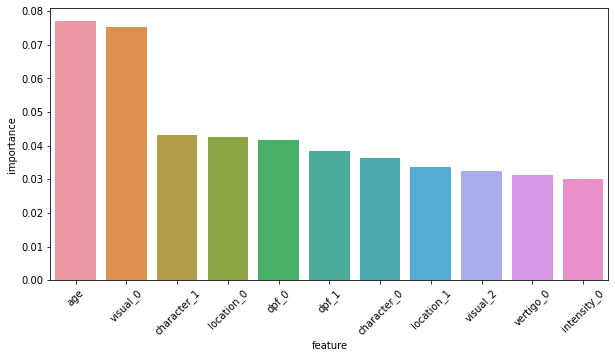

In [34]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='feature',y='importance', data=feat_importance.iloc[0:11, :])
plt.xticks(rotation = 45)
plt.show()

**KNN**

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [36]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)

predictions = knn.predict(X_test_scaled)

In [37]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.38      0.33      0.35         9
           2       0.89      0.94      0.92        18
           3       1.00      0.75      0.86         4
           4       0.33      0.25      0.29         4
           5       0.84      0.91      0.88        81
           6       1.00      1.00      1.00         7

    accuracy                           0.82       129
   macro avg       0.78      0.62      0.65       129
weighted avg       0.82      0.82      0.81       129



In [38]:
error_rate = []
# Will take some time
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))

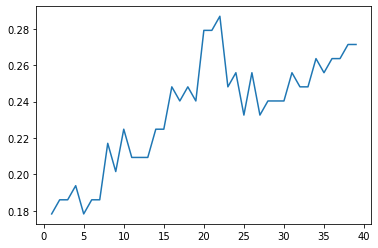

In [39]:
plt.plot(list(range(1,40)), error_rate)

**Voting Classifier**

In [40]:
from sklearn.ensemble import VotingClassifier

In [41]:
clf1 = LogisticRegression(max_iter=1000)
clf2 = RandomForestClassifier()
clf3 = KNeighborsClassifier()

estimators = [("logistic_regression", clf1), ("random_forest", clf2), ("knn", clf3)]

In [42]:
vc = VotingClassifier(estimators=estimators, voting="soft")
vc.fit(X_train_scaled, y_train)
predictions = vc.predict(X_test_scaled)

In [43]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.50      0.56      0.53         9
           2       0.90      1.00      0.95        18
           3       1.00      0.75      0.86         4
           4       0.33      0.50      0.40         4
           5       0.95      0.90      0.92        81
           6       1.00      1.00      1.00         7

    accuracy                           0.86       129
   macro avg       0.74      0.74      0.74       129
weighted avg       0.87      0.86      0.87       129

